In [1]:
import pandas as pd
import numpy as np
import catboost
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder

## Data preprocessing

In [2]:
df_for_learning = pd.read_csv("train.csv")
df_for_test = pd.read_csv("test.csv")
df_test_id = df_for_test["Id"]

In [3]:
def clean(df):
    df["Exterior2nd"] = df["Exterior2nd"].replace({"Brk Cmn": "BrkComm"})
    # Some values of GarageYrBlt are corrupt, so we'll replace them
    # with the year the house was built
    df["GarageYrBlt"] = df["GarageYrBlt"].where(df.GarageYrBlt <= 2010, df.YearBuilt)
    # Names beginning with numbers are awkward to work with
    df.rename(columns={
        "1stFlrSF": "FirstFlrSF",
        "2ndFlrSF": "SecondFlrSF",
        "3SsnPorch": "Threeseasonporch",
    }, inplace=True,
    )
    return df

In [4]:
df_for_learning = clean(df_for_learning)
df_for_test = clean(df_for_test)

In [5]:
df_for_learning.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
df_for_learning.shape

(1460, 81)

Analysis of the missing data

In [7]:
data_miss_values_sum = df_for_learning.isna().sum().sort_values(ascending=False)
data_miss_values_mean = df_for_learning.isna().mean().sort_values(ascending=True)
miss_values_summary = pd.concat([data_miss_values_sum,data_miss_values_mean], axis=1, keys=['Total', 'Percentage'])
miss_values_summary.head(20)

,Total,Percentage
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageQual,81,0.055479
GarageType,81,0.055479
GarageFinish,81,0.055479


In [8]:
# choose features with most numbers of missing values
# take a look at them
columns_with_many_missings_number = 5
percentage_threshhold = 0.4
columns_with_many_missings = list(miss_values_summary[miss_values_summary['Percentage']>percentage_threshhold].index)
columns_with_many_missings

['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu']

In [9]:
for column in columns_with_many_missings:
    print(f'Feature {column}')
    display(df_for_learning[column].value_counts(dropna=False))

Feature PoolQC


NaN    1453
Gd        3
Ex        2
Fa        2
Name: PoolQC, dtype: int64

Feature MiscFeature


NaN     1406
Shed      49
Gar2       2
Othr       2
TenC       1
Name: MiscFeature, dtype: int64

Feature Alley


NaN     1369
Grvl      50
Pave      41
Name: Alley, dtype: int64

Feature Fence


NaN      1179
MnPrv     157
GdPrv      59
GdWo       54
MnWw       11
Name: Fence, dtype: int64

Feature FireplaceQu


NaN    690
Gd     380
TA     313
Fa      33
Ex      24
Po      20
Name: FireplaceQu, dtype: int64

In [10]:
# function for replacing NaNs with means and modes 
# (depends on dtype of variable)
def remove_nans_custom(df):
    obj_features = list(df.select_dtypes(include=['object']).columns)
    int_features = list(df.select_dtypes(include=['int64','float64']).columns)
    df[int_features] = df[int_features].apply(lambda x: x.fillna(x.interpolate(method='spline',order = 3)))
#     df[int_features] = df[int_features].apply(lambda x: x.fillna(x.fillna(x.mean())))
    df[obj_features] = df[obj_features].apply(lambda x: x.fillna(x.value_counts().index[0]))
    return df

Remove all columns with too many NaNs and replace in remaining ones NaN with means and modes

In [11]:
df_for_learning_no_missing = df_for_learning.drop(columns = columns_with_many_missings)
df_for_learning_no_missing = remove_nans_custom(df_for_learning_no_missing)
df_for_test_no_missing = df_for_test.drop(columns = columns_with_many_missings)
df_for_test_no_missing = remove_nans_custom(df_for_test_no_missing)

Let's remove all features which are almost constant (consist more than 95% of a certain value)

In [12]:
def get_almost_constant_columns(df, type_of_columns):
    almost_constant_column = [feature for feature in df.select_dtypes(include = type_of_columns).columns
                 if df[feature].value_counts(normalize=True).values[0] > 0.8]
    return almost_constant_column

In [13]:
for feature in df_for_learning_no_missing.select_dtypes(include=['object']).columns:
    threshold = df_for_learning_no_missing[feature].value_counts(normalize=True)[0]
    if threshold > 0.8:
        print(feature)
        print(df_for_learning_no_missing[feature].value_counts())

Street
Pave    1454
Grvl       6
Name: Street, dtype: int64
LandContour
Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64
Utilities
AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64
LandSlope
Gtl    1382
Mod      65
Sev      13
Name: LandSlope, dtype: int64
Condition1
Norm      1260
Feedr       81
Artery      48
RRAn        26
PosN        19
RRAe        11
PosA         8
RRNn         5
RRNe         2
Name: Condition1, dtype: int64
Condition2
Norm      1445
Feedr        6
PosN         2
Artery       2
RRNn         2
RRAe         1
PosA         1
RRAn         1
Name: Condition2, dtype: int64
BldgType
1Fam      1220
TwnhsE     114
Duplex      52
Twnhs       43
2fmCon      31
Name: BldgType, dtype: int64
RoofMatl
CompShg    1434
Tar&Grv      11
WdShngl       6
WdShake       5
Metal         1
ClyTile       1
Membran       1
Roll          1
Name: RoofMatl, dtype: int64
ExterCond
TA    1282
Gd     146
Fa      28
Ex       3
Po       1
Name: ExterCond, dt

In [14]:
# remove all columns which consist on 95%+ of the same value
almost_constant_column = get_almost_constant_columns(df_for_learning_no_missing,['object'])
almost_constant_column

['Street',
 'LandContour',
 'Utilities',
 'LandSlope',
 'Condition1',
 'Condition2',
 'BldgType',
 'RoofMatl',
 'ExterCond',
 'BsmtCond',
 'BsmtFinType2',
 'Heating',
 'CentralAir',
 'Electrical',
 'Functional',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'SaleType',
 'SaleCondition']

In [15]:
df_for_learning_no_missing.drop(columns = almost_constant_column,inplace=True)
df_for_test_no_missing.drop(columns = almost_constant_column,inplace=True)

Analyze categorical features, which values they contain

In [16]:
for feature in df_for_learning_no_missing.select_dtypes(include=['object']).columns:
    threshold = df_for_learning_no_missing[feature].value_counts(normalize=True)[0]
    if (threshold <= 0.8) and (threshold > 0.70):
        print(feature)
        print(df_for_learning_no_missing[feature].value_counts())

MSZoning
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64
LotConfig
Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64
RoofStyle
Gable      1141
Hip         286
Flat         13
Gambrel      11
Mansard       7
Shed          2
Name: RoofStyle, dtype: int64


Some of them may be binarized (features consisting between 70 and 95% of the same value)

Function beneath had been made for that purpose 

In [17]:
def binarize_features(df_tr, df_test, type_of_columns):
    for feature in df_tr.select_dtypes(include = type_of_columns).columns:
        trhreshold = df_tr[feature].value_counts(normalize=True).values[0]
        if (trhreshold <= 0.8) and (trhreshold > 0.7):
            most_freq_el = df_tr[feature].value_counts().index[0]
            new_feature_name = feature + "_" + str(most_freq_el)
            df_tr[new_feature_name] = df_tr[feature] == most_freq_el
            df_tr.drop(columns = [feature],inplace=True)
            df_test[new_feature_name] = df_test[feature] == most_freq_el
            df_test.drop(columns = [feature],inplace=True)

In [18]:
binarize_features(df_for_learning_no_missing,df_for_test_no_missing, 'object')

Numerical features should be analyzed too, maybe they can be binarized as well

In [19]:
for feature in df_for_learning_no_missing.select_dtypes(include = ['int64','float64']).columns:
    threshold = df_for_learning_no_missing[feature].value_counts(normalize=True).values[0]
    if  (threshold > 0.60):
        print(feature)
        print(df_for_learning_no_missing[feature].value_counts(normalize=True))

BsmtFinSF2
0       0.885616
180     0.003425
374     0.002055
117     0.001370
391     0.001370
          ...   
215     0.000685
211     0.000685
210     0.000685
208     0.000685
1474    0.000685
Name: BsmtFinSF2, Length: 144, dtype: float64
LowQualFinSF
0      0.982192
80     0.002055
360    0.001370
392    0.000685
528    0.000685
515    0.000685
514    0.000685
513    0.000685
481    0.000685
479    0.000685
473    0.000685
420    0.000685
397    0.000685
390    0.000685
53     0.000685
384    0.000685
371    0.000685
234    0.000685
232    0.000685
205    0.000685
156    0.000685
144    0.000685
120    0.000685
572    0.000685
Name: LowQualFinSF, dtype: float64
BsmtHalfBath
0    0.943836
1    0.054795
2    0.001370
Name: BsmtHalfBath, dtype: float64
HalfBath
0    0.625342
1    0.366438
2    0.008219
Name: HalfBath, dtype: float64
KitchenAbvGr
1    0.953425
2    0.044521
3    0.001370
0    0.000685
Name: KitchenAbvGr, dtype: float64
EnclosedPorch
0      0.857534
112    0.010274
96

You see, there are many feaures can be binarized or totally removed

In [20]:
almost_constant_column_int = get_almost_constant_columns(df_for_learning_no_missing,['int64','float64'])
almost_constant_column_int

['BsmtFinSF2',
 'LowQualFinSF',
 'BsmtHalfBath',
 'KitchenAbvGr',
 'EnclosedPorch',
 'Threeseasonporch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal']

In [21]:
# df_for_learning_no_missing.drop(columns = almost_constant_column_int, inplace = True)
# df_for_test_no_missing.drop(columns = almost_constant_column_int, inplace = True)

Binarize all feauters with a value's dominance

In [22]:
# binarize_features(df_for_learning_no_missing, df_for_test_no_missing, ['int64','float64'])

Let's take a look how SalePrice depends on other columns

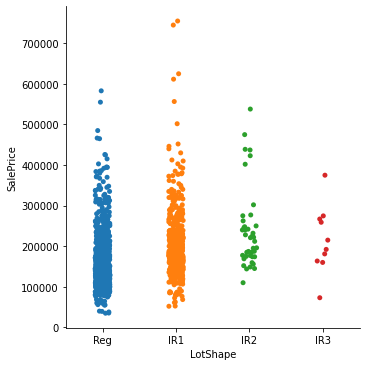

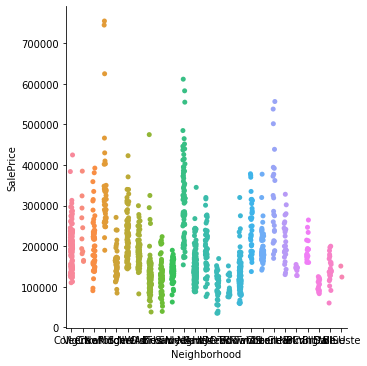

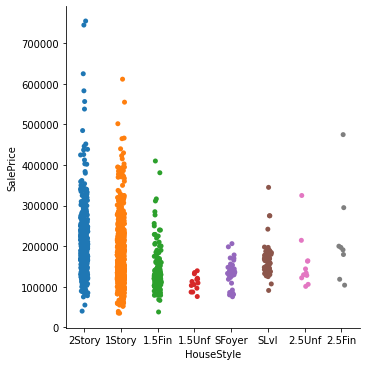

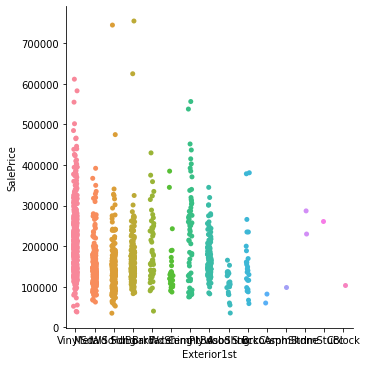

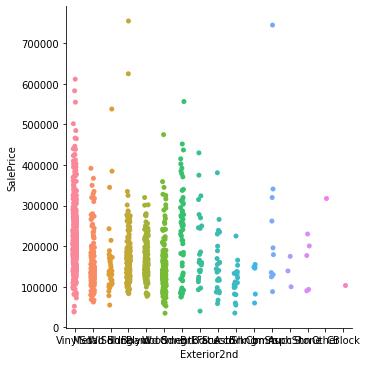

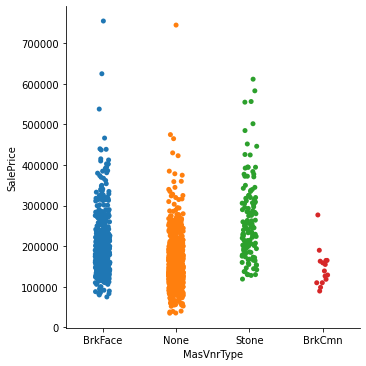

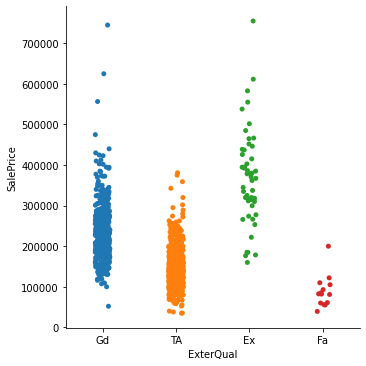

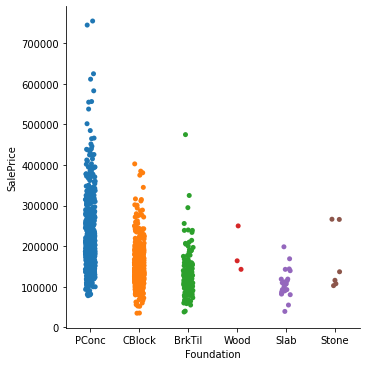

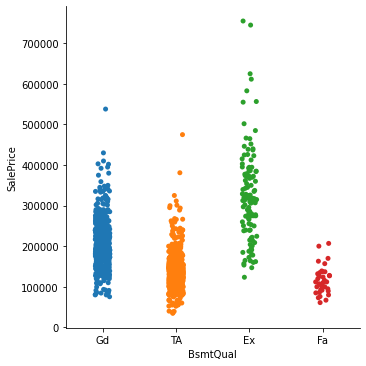

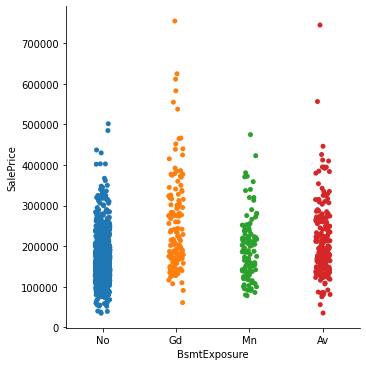

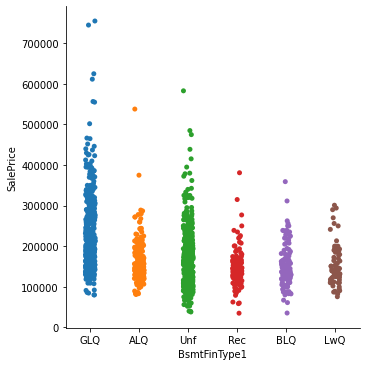

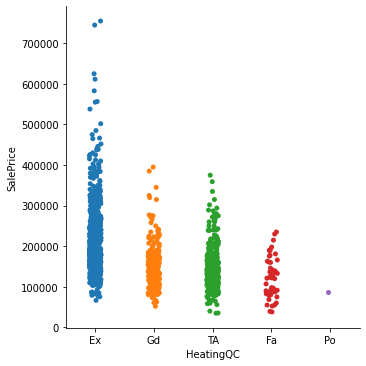

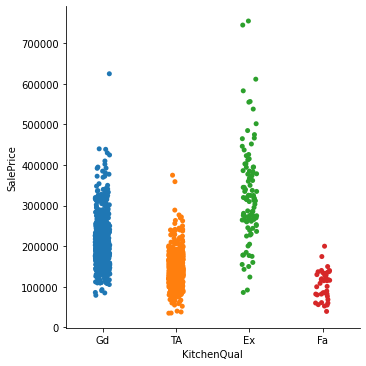

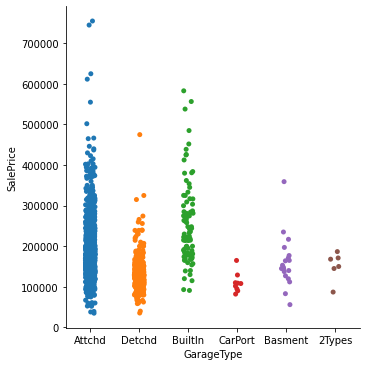

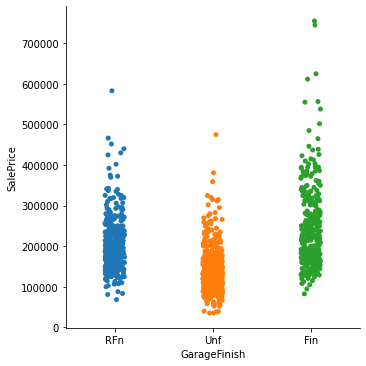

In [23]:
for feature_obj in df_for_learning_no_missing.select_dtypes(include=['object']).columns:
    sns.catplot(x=df_for_learning_no_missing[feature_obj], y=df_for_learning_no_missing['SalePrice'], data=df_for_learning)
    plt.show()

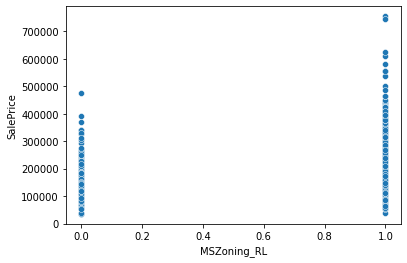

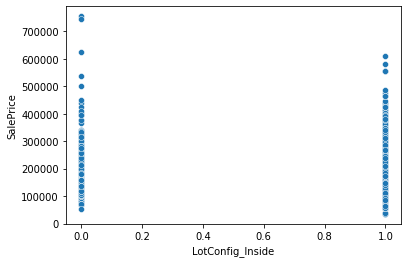

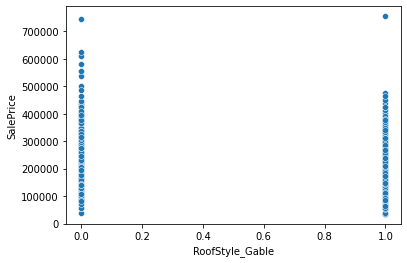

In [24]:
for feature_obj in df_for_learning_no_missing.select_dtypes(include=['bool']).columns:
    sns.scatterplot(x=df_for_learning_no_missing[feature_obj], y=df_for_learning_no_missing['SalePrice'])
    plt.show()

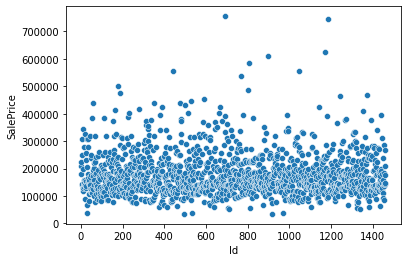

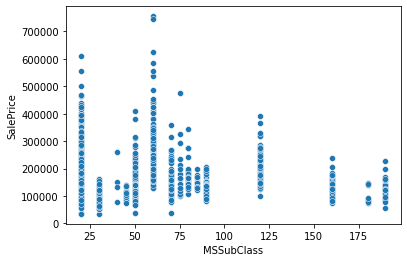

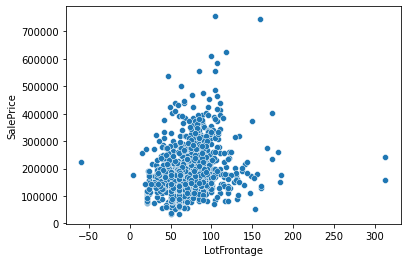

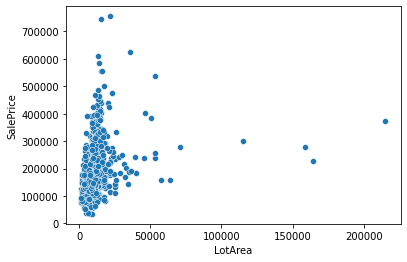

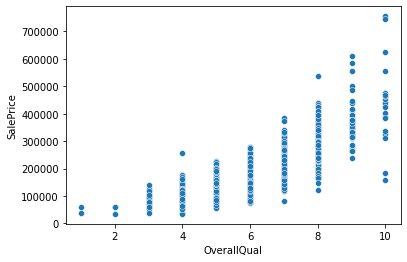

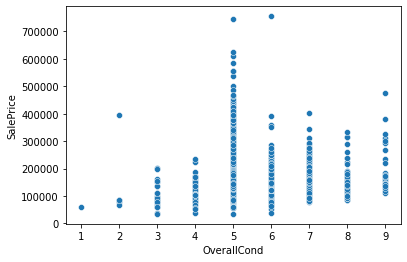

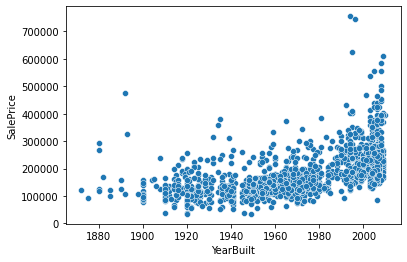

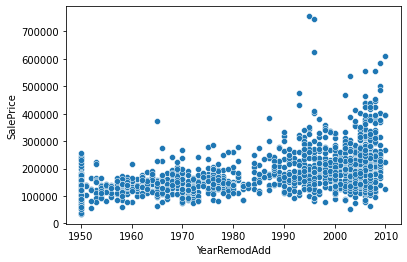

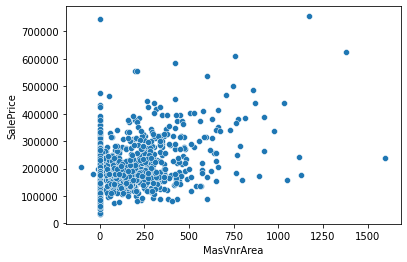

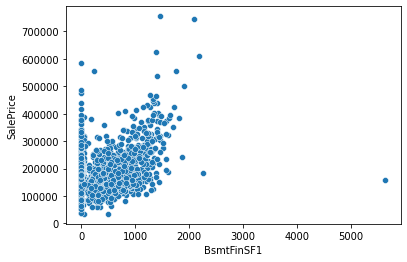

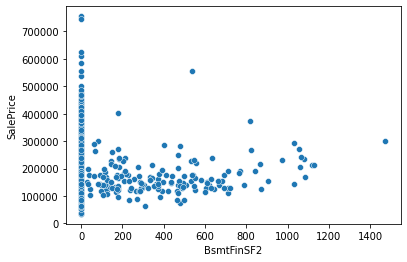

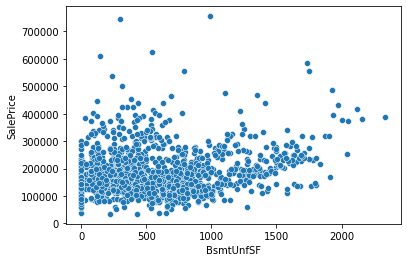

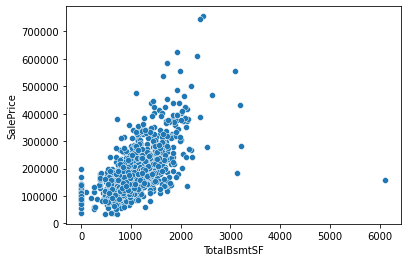

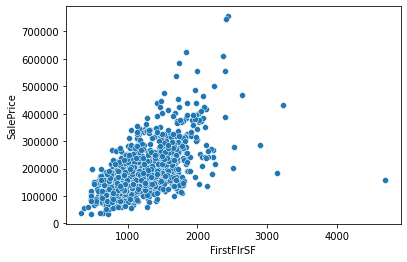

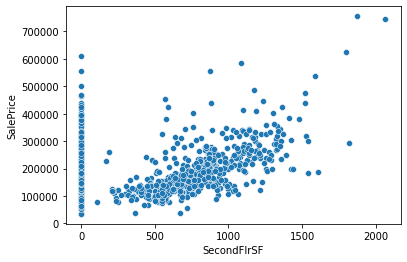

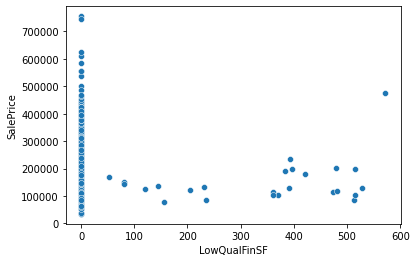

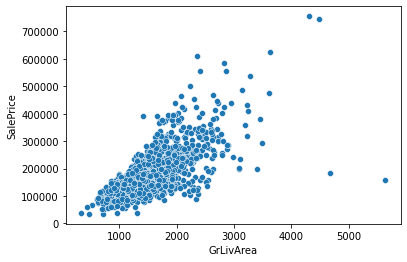

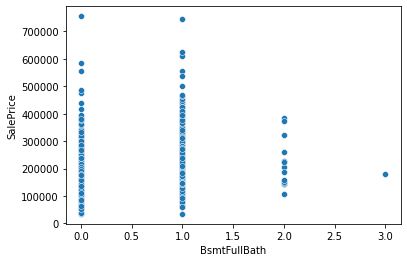

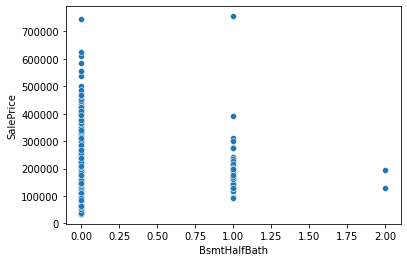

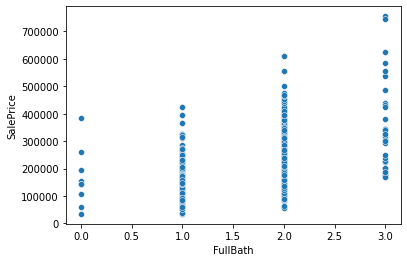

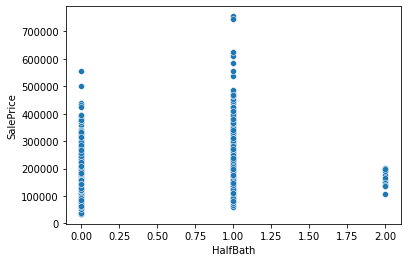

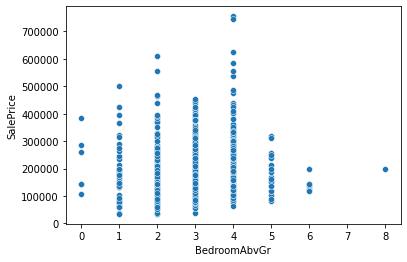

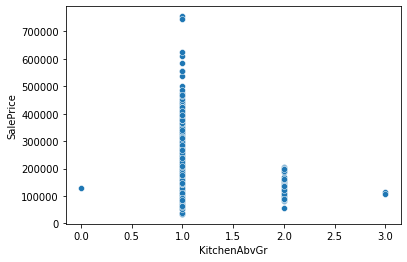

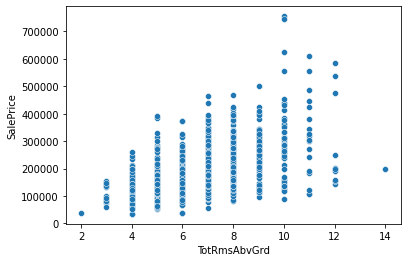

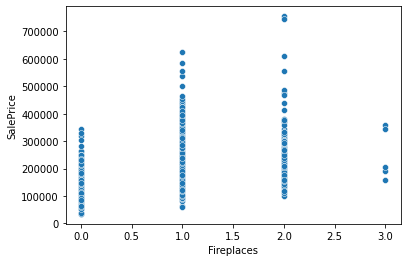

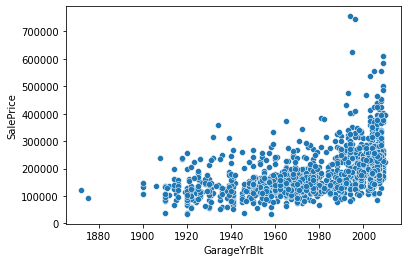

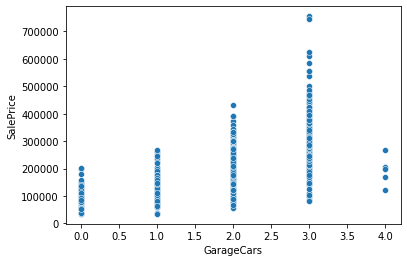

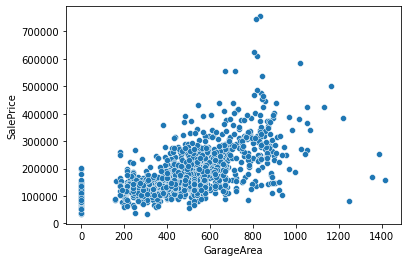

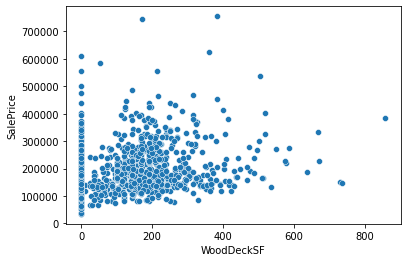

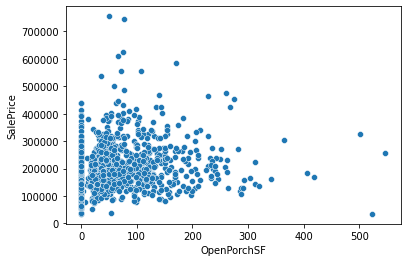

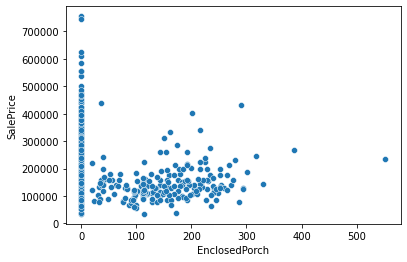

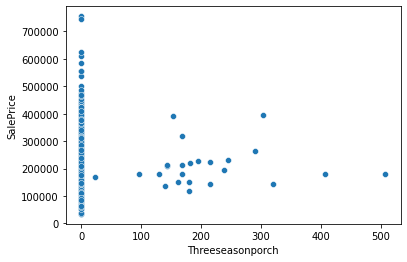

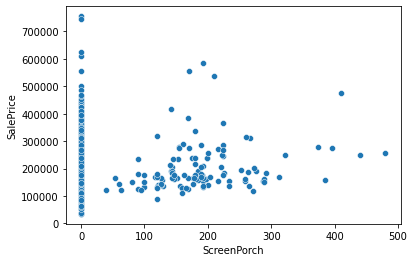

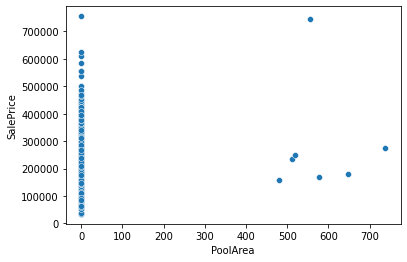

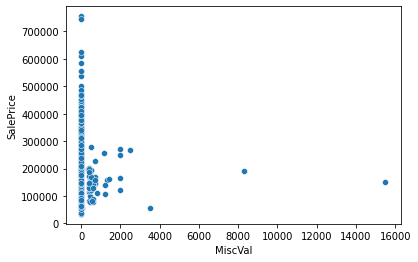

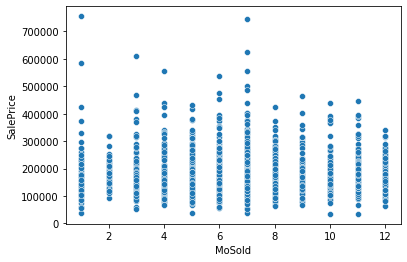

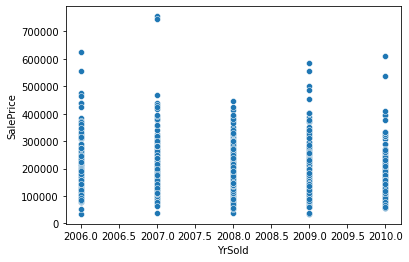

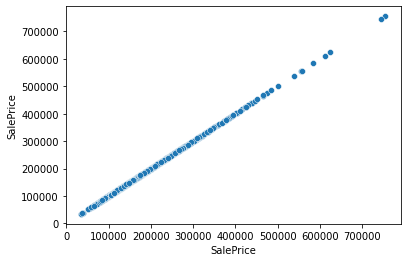

In [25]:
for feature_obj in df_for_learning_no_missing.select_dtypes(include=['int64','float64']).columns:
    sns.scatterplot(x=df_for_learning_no_missing[feature_obj], y=df_for_learning_no_missing['SalePrice'])
    plt.show()

Looking at the graphs above we may see outliers just visually and remove them

In [26]:
df_for_learning_no_missing = df_for_learning_no_missing[df_for_learning_no_missing.HeatingQC != 'Po']
df_for_learning_no_missing = df_for_learning_no_missing[df_for_learning_no_missing.GrLivArea < 4500]
df_for_learning_no_missing = df_for_learning_no_missing[df_for_learning_no_missing.SalePrice < 700000]
df_for_learning_no_missing = df_for_learning_no_missing[df_for_learning_no_missing.TotRmsAbvGrd < 14]
df_for_learning_no_missing = df_for_learning_no_missing[df_for_learning_no_missing.OpenPorchSF < 500]
df_for_learning_no_missing = df_for_learning_no_missing[df_for_learning_no_missing.WoodDeckSF < 800]
df_for_learning_no_missing = df_for_learning_no_missing[df_for_learning_no_missing.BedroomAbvGr < 8]
df_for_learning_no_missing = df_for_learning_no_missing[df_for_learning_no_missing.BsmtFullBath < 3]
df_for_learning_no_missing = df_for_learning_no_missing[df_for_learning_no_missing.BsmtFullBath < 3]
df_for_learning_no_missing = df_for_learning_no_missing[df_for_learning_no_missing.FirstFlrSF < 4000]
df_for_learning_no_missing = df_for_learning_no_missing[df_for_learning_no_missing.TotalBsmtSF < 4000]
df_for_learning_no_missing = df_for_learning_no_missing[df_for_learning_no_missing.BsmtFinSF1 < 5000]
df_for_learning_no_missing = df_for_learning_no_missing[df_for_learning_no_missing.MasVnrArea < 1500]
df_for_learning_no_missing = df_for_learning_no_missing[df_for_learning_no_missing.LotArea < 100000]
df_for_learning_no_missing = df_for_learning_no_missing[df_for_learning_no_missing.LotFrontage < 200]

looking at the graphs above, we can conclude that some features are not important (mutual distribution with target variable is uniform) and may be removed

In [27]:
not_importatnt = ["Exterior1st","Exterior2nd","Foundation","YrSold"]
df_for_learning_no_missing = df_for_learning_no_missing.drop(columns = not_importatnt)
df_for_test_no_missing = df_for_test_no_missing.drop(columns = not_importatnt)

In [28]:
obj_features = df_for_learning_no_missing.select_dtypes(include=['object']).columns
numerical_features = df_for_learning_no_missing.select_dtypes(include=['int64','float64']).columns
binary_features = df_for_learning_no_missing.select_dtypes(include=['bool']).columns

## Correlation Analysis

In [29]:
df_for_corr = df_for_learning_no_missing.copy()

In [30]:
LE =LabelEncoder()

In [31]:
for obj_feature in obj_features:
    df_for_corr[obj_feature] = LE.fit_transform(df_for_corr[obj_feature])

Корреляция между категориальными признаками

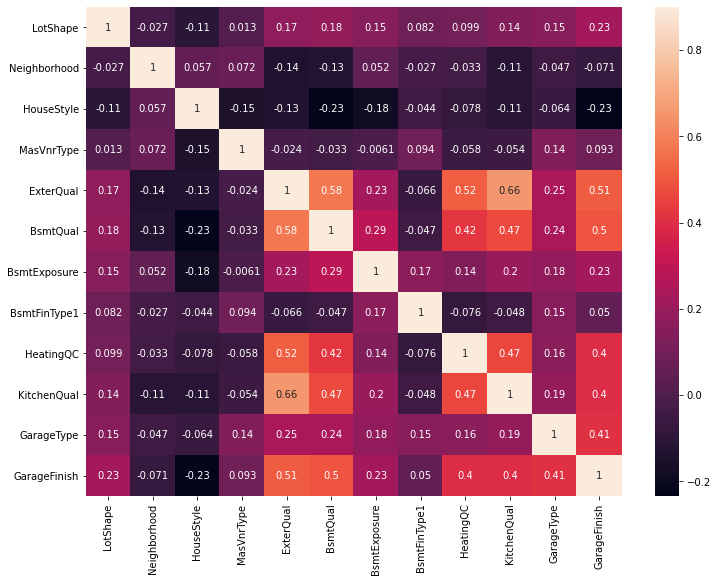

In [32]:
corr_matrix = df_for_corr[obj_features].corr('spearman')
f, ax1 = plt.subplots(figsize=(12,9)) 
ax1=sns.heatmap(corr_matrix,vmax = 0.9, annot = True); 

Correlation between binary features

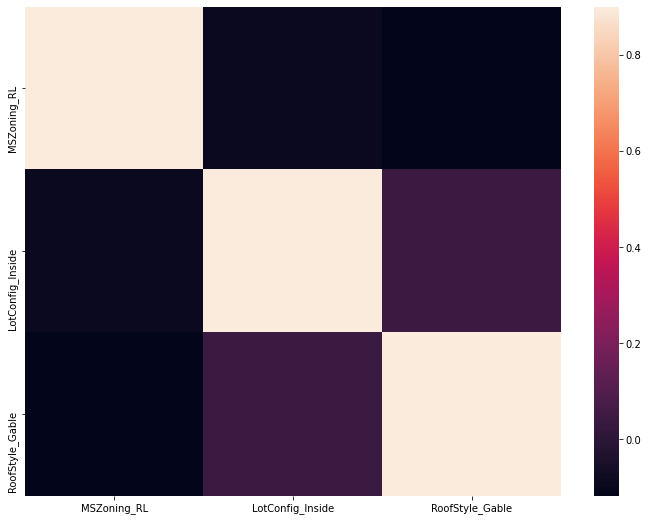

In [33]:
corr_matrix = df_for_corr[binary_features].corr()
f, ax1 = plt.subplots(figsize=(12,9)) 
ax1=sns.heatmap(corr_matrix,vmax = 0.9); 

Correlation between numerical features

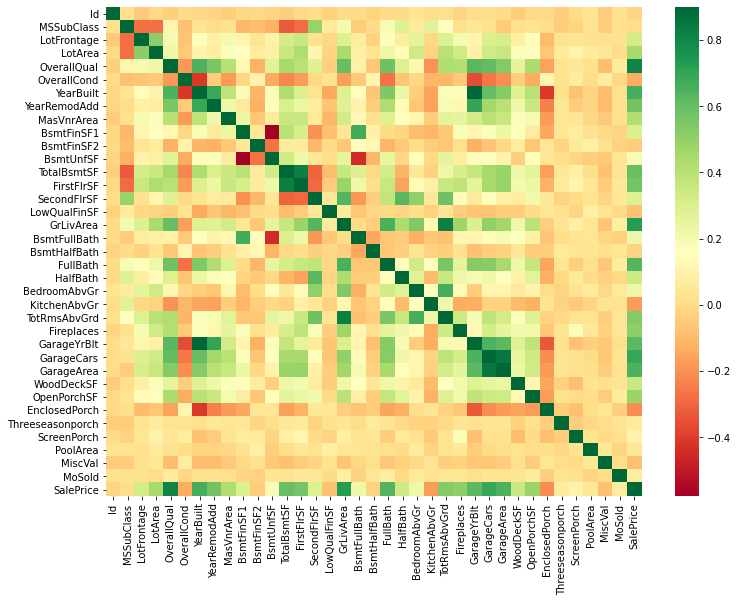

In [34]:
corr_matrix = df_for_corr[numerical_features].corr('spearman')
f, ax1 = plt.subplots(figsize=(12,9)) 
ax1=sns.heatmap(corr_matrix,vmax = 0.9, cmap="RdYlGn"); 

<AxesSubplot:xlabel='GarageCars', ylabel='GarageArea'>

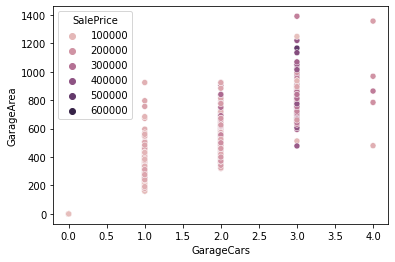

In [40]:
sns.scatterplot(data = df_for_learning_no_missing, x = 'GarageCars', y = 'GarageArea', hue = 'SalePrice')

In [35]:
corr_for_SalePrice = corr_matrix = pd.DataFrame(df_for_corr.corr('spearman')["SalePrice"])
corr_for_SalePrice.columns = ['Corr_Value']
corr_for_SalePrice.sort_values(by = 'Corr_Value', key = lambda x: np.abs(x),ascending = False, inplace = True)
corr_for_SalePrice

,Corr_Value
SalePrice,1.000000
OverallQual,0.811387
GrLivArea,0.727624
GarageCars,0.693308
YearBuilt,0.663574
GarageArea,0.649979
FullBath,0.635633
ExterQual,-0.634976
GarageYrBlt,0.621937
GarageFinish,-0.621077


In [36]:
less_corr_features = corr_matrix.index[abs(corr_for_SalePrice["Corr_Value"]) < 0.1]
less_corr_features = list(less_corr_features)
less_corr_features

['ScreenPorch',
 'BsmtFinType1',
 'LotConfig_Inside',
 'MiscVal',
 'MasVnrType',
 'MoSold',
 'LowQualFinSF',
 'Threeseasonporch',
 'PoolArea',
 'BsmtFinSF2',
 'BsmtHalfBath',
 'Id',
 'MSSubClass']

Remove all features only a little bit correlated with the SalePrice column (let it be less than 10%)

In [37]:
df_for_learning_no_missing.drop(less_corr_features,axis = 1, inplace = True)
df_for_test_no_missing.drop(less_corr_features,axis = 1, inplace = True)

In [38]:
df_for_learning_no_missing.describe()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,...,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,SalePrice
count,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000,...,1443.000000,1443.000000,1443.00000,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000
mean,69.882018,9989.979903,6.085239,5.571726,1971.361053,1984.846847,101.260974,434.105336,567.844075,1048.376992,...,1.046431,6.500347,0.60499,1976.596674,1.765766,471.724879,93.201663,45.313929,21.963964,179604.536383
std,23.296517,5298.546396,1.366966,1.112072,30.142874,20.641433,172.958108,428.293815,442.239359,411.169563,...,0.220152,1.599833,0.63685,26.253951,0.744294,211.103934,122.775040,61.802484,61.109575,76267.300147
min,-59.560696,1300.000000,1.000000,1.000000,1872.000000,1950.000000,-103.945814,0.000000,0.000000,0.000000,...,0.000000,2.000000,0.00000,1872.000000,0.000000,0.000000,0.000000,0.000000,0.000000,35311.000000
25%,58.000000,7517.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,223.500000,795.000000,...,1.000000,5.000000,0.00000,1959.000000,1.000000,329.000000,0.000000,0.000000,0.000000,129900.000000
50%,70.000000,9450.000000,6.000000,5.000000,1973.000000,1994.000000,0.000000,378.000000,480.000000,990.000000,...,1.000000,6.000000,1.00000,1978.000000,2.000000,478.000000,0.000000,24.000000,0.000000,162000.000000
75%,81.000000,11506.000000,7.000000,6.000000,2001.000000,2004.000000,164.500000,705.500000,808.000000,1285.000000,...,1.000000,7.000000,1.00000,2001.000000,2.000000,576.000000,168.000000,67.500000,0.000000,213000.000000
max,185.802402,70761.000000,10.000000,9.000000,2010.000000,2010.000000,1378.000000,2188.000000,2336.000000,3206.000000,...,3.000000,12.000000,3.00000,2010.000000,4.000000,1390.000000,736.000000,418.000000,552.000000,625000.000000


## Some preparations before train

<AxesSubplot:>

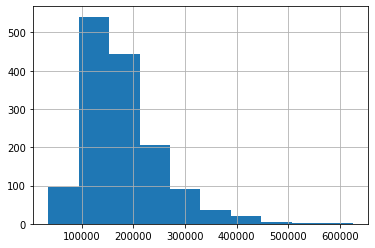

In [39]:
df_for_learning_no_missing['SalePrice'].hist()

In [ ]:
np.log1p(df_for_learning_no_missing['SalePrice']).hist(bins=40)

<AxesSubplot:>

Obviously, target variable is normally distributed, so we may use 3-sigma rule to remove outliers

removing outliers

In [ ]:
def dealing_with_outliers(df):
    obj_features = list(df.select_dtypes(include=['object']).columns)
    int_features = list(df.select_dtypes(include=['int64','float64']).columns)
    if 'SalePrice' in int_features:
        int_features.remove('SalePrice')
#     Q1 = df[int_features].quantile(0.25)
#     Q3 = df[int_features].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 -(1.5 * IQR) 
#     upper_bound = Q3 +(1.5 * IQR)
#     Q1 = df['SalePrice'].quantile(0.25)
#     Q3 = df['SalePrice'].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 -(1.5 * IQR) 
#     upper_bound = Q3 +(1.5 * IQR)
#     df = df[(df['SalePrice'] > lower_bound) & (df['SalePrice'] < upper_bound)]
#     for col in df[int_features]:
#          Q1 = df[col].quantile(0.25)
#          Q3 = df[col].quantile(0.75)
#          IQR = Q3 - Q1
#          lower_bound = Q1 -(1.5 * IQR) 
#          upper_bound = Q3 +(1.5 * IQR)
#          df[col] = df[col].apply(lambda x: x if x>lower_bound else lower_bound) 
#          df[col] = df[col].apply(lambda x: x if x<upper_bound else  upper_bound) 
#     df = df[~((df[int_features] < (Q1 - 1.5 * IQR)) |(df[int_features] > (Q3 + 1.5 * IQR))).any(axis=1)]
    for feature in obj_features:
        counts = df[feature].value_counts()
        df = df[df[feature].isin(counts[counts > 2].index)]
#     for int_feature in int_features:
#         df[int_feature] = df[int_feature].map(lambda i: np.log(i) if i > 0 else 0) 
#     z = np.abs(stats.zscore(df[int_features]))
#     df = df[(z < 3).all(axis=1)]
    #df = df.reset_index()
#     df['z'] = np.abs(stats.zscore(df['SalePrice']))
#     df = df[df['z'] < 3]
#     df.drop(columns = ['z'], inplace = True)
    return df

In [ ]:
# df_for_learning_no_missing = dealing_with_outliers(df_for_learning_no_missing)

In [ ]:
df_for_learning_no_missing.shape

In [ ]:
def Scale_numerical_df(df_train,df_test):
    int_features = list(df_test.select_dtypes(include=['int64','float64']).columns)
    #Scaler = RobustScaler()
    Scaler = StandardScaler()
    Scaler.fit(df_train[int_features])
    df_train[int_features]=Scaler.transform(df_train[int_features])
    df_test[int_features]=Scaler.transform(df_test[int_features])
    return df_train, df_test

Data Normalization (numerical features)

In [ ]:
df_for_learning_no_missing, df_for_test_no_missing = Scale_numerical_df(df_for_learning_no_missing, df_for_test_no_missing)

In [ ]:
train_data, val_data, train_value, val_value = train_test_split(df_for_learning_no_missing.drop(columns = "SalePrice"), df_for_learning_no_missing.SalePrice, test_size = 0.2, random_state=2021 )

In [ ]:
np.log1p(train_value).hist(bins=40)

In [ ]:
np.log1p(val_value).hist(bins=40)

So we can see the target variable approximately disributed the same way between train and validation datasets

In [ ]:
cat_features = list(df_for_learning_no_missing.select_dtypes(include=['object','bool']).columns)
train_pool = catboost.Pool(
    train_data,
    label=train_value,
    cat_features = cat_features
)
val_pool = catboost.Pool(
    val_data,
    label = val_value,
    cat_features = cat_features
)

In [ ]:
catboost_train_dir = 'catboost_train_dir'
!rmdir /S /Q catboost_train_dir
!mkdir catboost_train_dir

In [ ]:
regr_model = catboost.CatBoostRegressor(
    # early_stopping_rounds=20,
    random_seed=2021,
    depth = 3,
    od_pval=0.05,
    od_wait=20,
    loss_function='RMSE',
    #learning_rate=0.1,
    iterations = 2000,
    train_dir=catboost_train_dir,
    task_type='GPU',
    # task_type='CPU',
    # devices='0',
    #auto_class_weights='Balanced',
    max_ctr_complexity=4,
    l2_leaf_reg = 1,
    use_best_model=True
)
regr_model.fit(
    train_pool, 
    eval_set=val_pool,
    plot=True,
    save_snapshot=True,
    snapshot_file='snapshot.bkp'
)

Write SalePrice prediction for test values in file

In [ ]:
df_to_csv = pd.DataFrame()
df_to_csv['SalePrice'] = regr_model.predict(df_for_test_no_missing)
df_to_csv['Id'] = df_test_id
df_to_csv.to_csv('answer.csv', index = False)

## Post-Hoc analysis

In [ ]:
features_importance = sorted(
    zip(train_data.columns, regr_model.feature_importances_), 
    key=lambda p: p[1], 
    reverse=True
)
important_features_cumulative = np.cumsum([feature[1] for feature in features_importance], axis = 0)
features_importance = pd.DataFrame(features_importance)
features_importance.columns = ['Feature','Feature_importance']
features_importance['Cumulative_sum'] = important_features_cumulative
features_importance['CorrWithSalePrice'] = [stats.spearmanr(df_for_learning_no_missing['SalePrice'],df_for_learning_no_missing[feature])[0]
                                            for feature in features_importance['Feature']]
features_importance

As we can see many important feautres also have strong correlation with the SalePrice, except NeigborHood (maybe because it is a categorical feature)

In [ ]:
shap_info = regr_model.get_feature_importance(
    data=train_pool, 
    type='ShapValues', 
    verbose=10000
)
shap_values = shap_info[:,:-1]
base_values = shap_info[:,-1]

In [ ]:
shap_values.shape

In [ ]:
shap.summary_plot(shap_values, train_data)